In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Evaluating Mean-Variance Optimization parameters

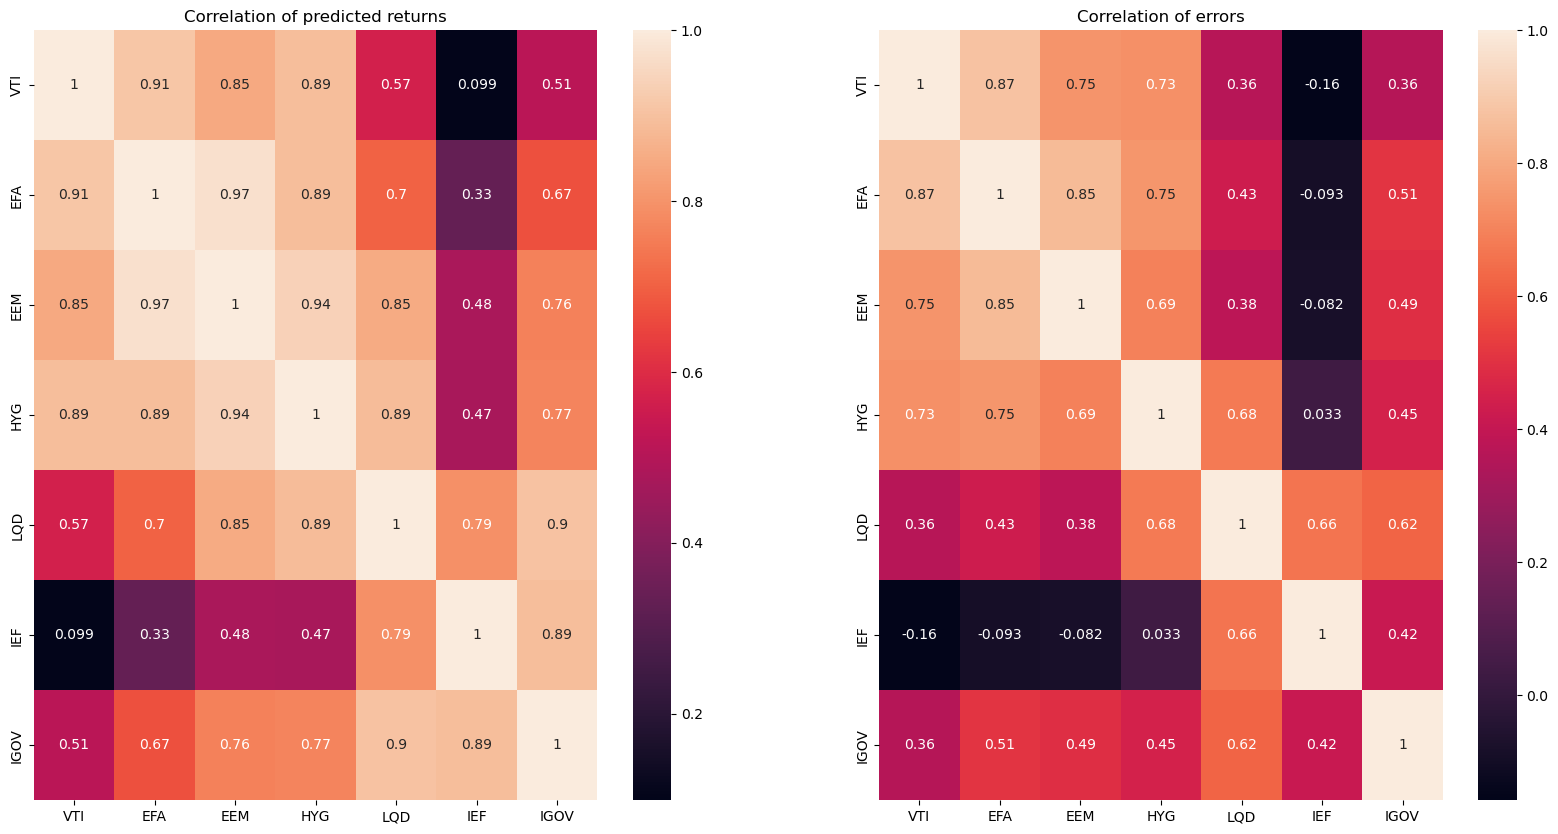

In [179]:
# Plot 2 heatmaps of the correlation of the predicted_er and the erorrs
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(predicted_er.corr(), annot=True, ax=ax[0])
ax[0].set_title('Correlation of predicted returns')
sns.heatmap(errors.corr(), annot=True, ax=ax[1])
ax[1].set_title('Correlation of errors')

plt.show()

In [305]:
# Portfolio weights

def optimize_weights(expected_returns, betas, cov_predicted, cov_errors, risk_aversion):
    """
    Optimize weights for a portfolio using a Fama-French 5-factor model.
    
    Parameters:
    - expected_returns (numpy array): vector of expected returns e[r]
    - betas (numpy array): matrix of factor loadings
    - cov_predicted (numpy array): covariance matrix of predicted returns
    - cov_errors (numpy array): covariance matrix of idiosyncratic returns
    - risk_aversion (float): risk-aversion parameter, lambda
    
    Returns:
    - weights (numpy array): optimized portfolio weights
    """
    # Dimensions
    n_assets = len(expected_returns)
    
    # Compute the term: beta' * cov_predicted * beta + cov_errors
    risk_matrix = np.dot(betas.T, np.dot(cov_predicted, betas)) + cov_errors
    
    # Set up the inverse of the risk-adjusted matrix with risk aversion
    inv_risk_matrix = np.linalg.inv(risk_aversion * risk_matrix)
    
    # Calculate the optimal weights with equality constraint (sum(weights) = 1)
    ones = np.ones(n_assets)
    A = np.dot(ones.T, np.dot(inv_risk_matrix, ones))
    B = np.dot(ones.T, np.dot(inv_risk_matrix, expected_returns))
    C = np.dot(expected_returns.T, np.dot(inv_risk_matrix, expected_returns))
    
    # Optimal weights calculation
    optimal_weights = np.dot(inv_risk_matrix, expected_returns - ((B - 1) / A) * ones)
    
    return optimal_weights

In [306]:
# Ensure all inputs are properly formatted as numpy arrays of type float64 and handle NaN values if any
predicted_expected_returns_vector = predicted_er.mean().values.astype(float)
betas_matrix = betas.drop(columns='const').values.T.astype(float)
cov_predicted = monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].cov().values.astype(float)
cov_errors = errors.cov().values.astype(float)
risk_aversion = 1

# Call the function with updated inputs
weights = optimize_weights(predicted_expected_returns_vector, betas_matrix, cov_predicted, cov_errors, risk_aversion)
# Print a dataframe of asset class with its corresponding weight
weights_df = pd.DataFrame(weights, index=asset_classes, columns=['Weight'])
display(weights_df)

,Weight
VTI,9.404033
EFA,-2.835077
EEM,3.935369
HYG,-15.653025
LQD,18.461797
IEF,0.021136
IGOV,-12.334234


In [307]:
# Compute the expected returns of the portfolio as: risk free +(sum over factors of the sum over the assets of the weight of the asset times the beta of the asset) times the factor expected return
expected_portfolio_return = monthly_data['RF'].loc['2024-07-31'] + np.dot(weights, betas_matrix.T) @ monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean().values
expected_ew_portfolio_return = monthly_data[asset_classes].mean().mean()

ew_weights = np.ones(len(asset_classes)) / len(asset_classes)

# Compute the portfolio volatility by 
vol_portfolio = weights.T @ betas_matrix.T @ cov_predicted @ betas_matrix @ weights + weights.T @ cov_errors @ weights
vol_ew_portfolio = ew_weights.T @ betas_matrix.T @ cov_predicted @ betas_matrix @ ew_weights + ew_weights.T @ cov_errors @ ew_weights

# Dataframe of the portfolio returns, volatility and Sharpe ratio annualized
analytics = pd.DataFrame(index=['Portfolio'], columns=['Return', 'Volatility', 'Sharpe Ratio'])
analytics['Return'] = expected_portfolio_return * 12
analytics['Volatility'] = vol_portfolio * np.sqrt(12)
analytics['Sharpe Ratio'] = analytics['Return'] / analytics['Volatility']

# add the equally weighted portfolio to the dataframe
analytics.loc['EW Portfolio'] = [expected_ew_portfolio_return * 12, vol_ew_portfolio * np.sqrt(12), expected_ew_portfolio_return / vol_ew_portfolio]


display(analytics)

,Return,Volatility,Sharpe Ratio
Portfolio,0.063764,0.333379,0.191265
EW Portfolio,0.058898,0.002846,5.973454


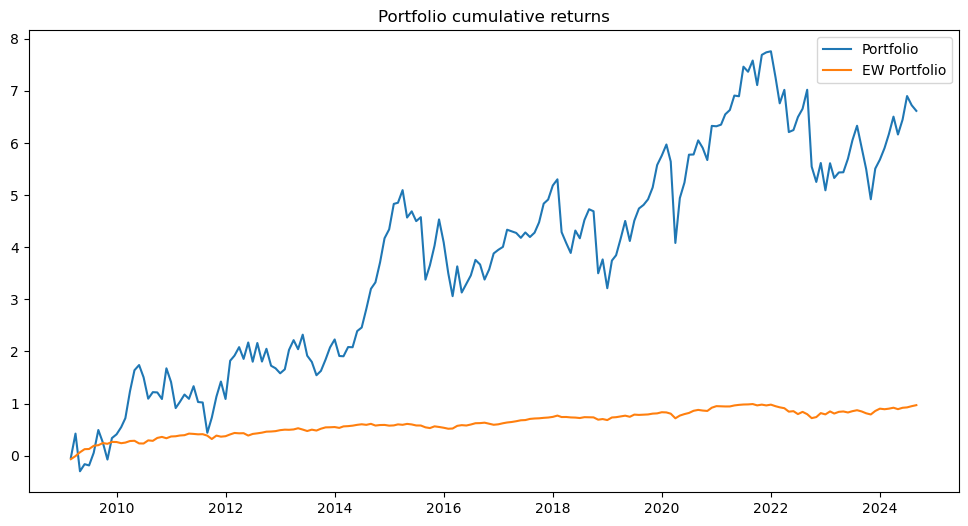

In [308]:
# Plot tbe cumulative returns of the portfolio and the equally weighted portfolio
portfolio_cum_rets = (1 + monthly_data[asset_classes] @ weights).cumprod().apply(np.log)
ew_portfolio_cum_rets = (1 + monthly_data[asset_classes] @ ew_weights).cumprod().apply(np.log)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(portfolio_cum_rets, label='Portfolio')
plt.plot(ew_portfolio_cum_rets, label='EW Portfolio')
plt.legend()
plt.title('Portfolio cumulative returns')
plt.show()

In [309]:
def optimize_weights(expected_returns, betas, cov_predicted, cov_errors, risk_aversion):
    """
    Optimize weights for a portfolio using a Fama-French 5-factor model with constraints.
    
    Parameters:
    - expected_returns (numpy array): vector of expected returns e[r]
    - betas (numpy array): matrix of factor loadings
    - cov_predicted (numpy array): covariance matrix of predicted returns
    - cov_errors (numpy array): covariance matrix of idiosyncratic returns
    - risk_aversion (float): risk-aversion parameter, lambda
    
    Returns:
    - weights (numpy array): optimized portfolio weights
    """
    # Compute the risk matrix term: beta' * cov_predicted * beta + cov_errors
    risk_matrix = np.dot(betas.T, np.dot(cov_predicted, betas)) + cov_errors

    # Define the objective function (negative because we are maximizing)
    def objective(weights):
        return -(np.dot(weights, expected_returns) - (risk_aversion / 2) * np.dot(weights.T, np.dot(risk_matrix, weights)))

    # Constraint: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    # Bounds: each weight should be between 0.20 and 0.40
    bounds = [(-0.40, 0.40) for _ in range(len(expected_returns))]

    # Initial guess (equal weighting)
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    # Perform the optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')

    # Check if the optimization was successful
    if not result.success:
        raise ValueError("Optimization did not converge: " + result.message)

    return result.x  # Optimized weights

# Parameters setup (ensure numpy arrays are in the correct format and dtype as before)
predicted_expected_returns_vector = predicted_er.mean().values.astype(float)
betas_matrix = betas.drop(columns='const').values.T.astype(float)
cov_predicted = monthly_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].cov().values.astype(float)
cov_errors = errors.cov().values.astype(float)
risk_aversion = 1

# Run the constrained optimization
weights = optimize_weights(predicted_expected_returns_vector, betas_matrix, cov_predicted, cov_errors, risk_aversion)
print("Optimal Weights:", weights)


Optimal Weights: [ 0.4         0.25550361  0.4         0.11823851  0.15018535  0.07607253
 -0.4       ]


In [310]:
# Backtest the portfolio
# Compute the portfolio returns
const_portfolio_returns = monthly_data[asset_classes] @ weights
const_portfolio_cum_rets = (1 + const_portfolio_returns).cumprod().apply(np.log)

# Compute the portfolio volatility
portfolio_volatility = np.sqrt(weights.T @ betas_matrix.T @ cov_predicted @ betas_matrix @ weights + weights.T @ cov_errors @ weights)

# Compute the portfolio Sharpe ratio
portfolio_sharpe = const_portfolio_returns.mean() / const_portfolio_returns.std()

# Add to the analytics dataframe
analytics.loc['Constrained Portfolio'] = [const_portfolio_returns.mean() * 12, portfolio_volatility * np.sqrt(12), portfolio_sharpe]


In [311]:
analytics

,Return,Volatility,Sharpe Ratio
Portfolio,0.063764,0.333379,0.191265
EW Portfolio,0.058898,0.002846,5.973454
Constrained Portfolio,0.132577,0.176820,0.229296


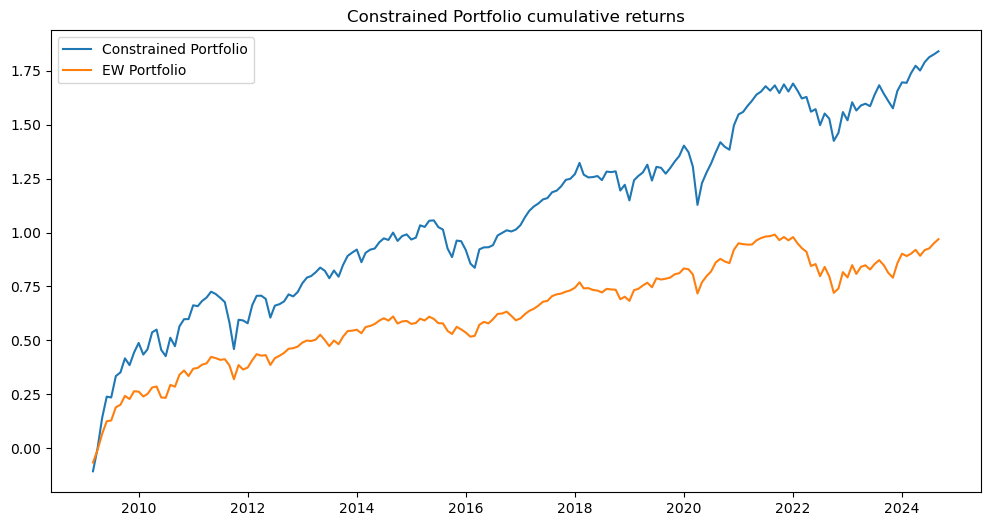

In [315]:
# Plot the cumulative returns of the constrained portfolio
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(const_portfolio_cum_rets, label='Constrained Portfolio')
plt.plot(ew_portfolio_cum_rets, label='EW Portfolio')
# plt.plot(portfolio_cum_rets, label='Portfolio')
plt.legend()
plt.title('Constrained Portfolio cumulative returns')
plt.show()
